In [13]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [14]:
df = pd.read_csv(r'E:\UG - Project\diabetes\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv')

In [15]:
df.drop(columns = ['max_glu_serum','A1Cresult'], inplace= True)

In [16]:

mapping = {'NO': 0, '>30': 1, '<30': 2}
df['readmitted_num'] = df['readmitted'].map(mapping)

# Verify the mapping
print(df[['readmitted', 'readmitted_num']].head())


  readmitted  readmitted_num
0         NO               0
1        >30               1
2         NO               0
3         NO               0
4         NO               0


## Preprocess features for clustering

For clustering, we usually ignore the target and just use features.
We’ll scale numeric features and encode categorical ones using OneHotEncoder.

In [17]:
X_cluster = df.drop(columns=['readmitted', 'readmitted_num'])

# Use same columns as before
numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]
ordinal_cols = ['age']
categorical_cols = [c for c in X_cluster.columns if c not in numeric_cols + ordinal_cols]

# Simple preprocessing for clustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]]))
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('ord', ordinal_pipe, ordinal_cols),
    ('cat', categorical_pipe, categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X_cluster)
print("Preprocessed shape for clustering:", X_preprocessed.shape)


Preprocessed shape for clustering: (101766, 175785)


## Reduce dimensions using PCA

In [18]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

print("Explained variance ratio:", pca.explained_variance_ratio_.sum())


Explained variance ratio: 0.21635552183139425


## K-Means Clustering

In [19]:
# Try different number of clusters (k=2 to 6)
k = 3  # you can tune this
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)

# Add cluster labels to PCA coords for plotting
import pandas as pd
df_clusters = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_clusters['cluster'] = clusters
df_clusters['readmitted'] = df['readmitted_num'].values


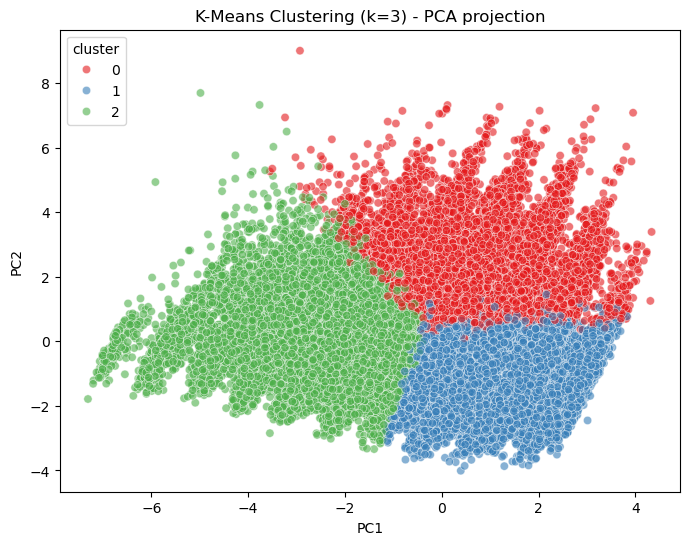

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.6)
plt.title(f"K-Means Clustering (k={k}) - PCA projection")
plt.show()

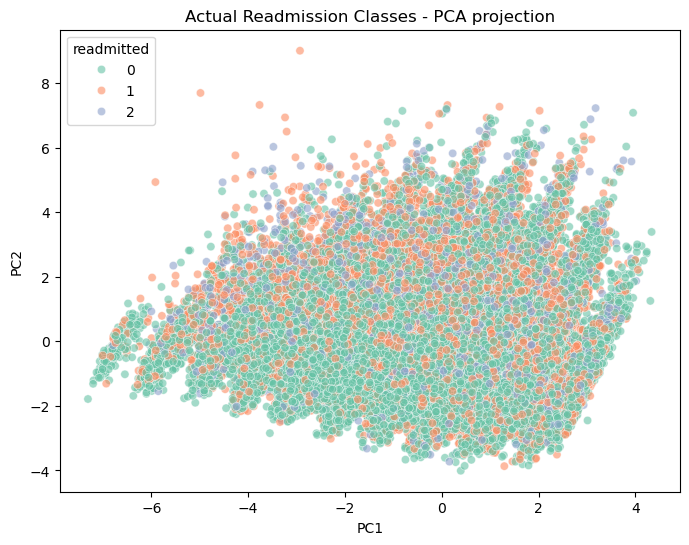

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='readmitted', palette='Set2', alpha=0.6)
plt.title("Actual Readmission Classes - PCA projection")
plt.show()

## Hierarchical Clustering

Builds a tree of clusters (dendrogram).

Good if you want to see nested clusters or don’t want to predefine the number of clusters.

Can use Agglomerative Clustering in scikit-learn.

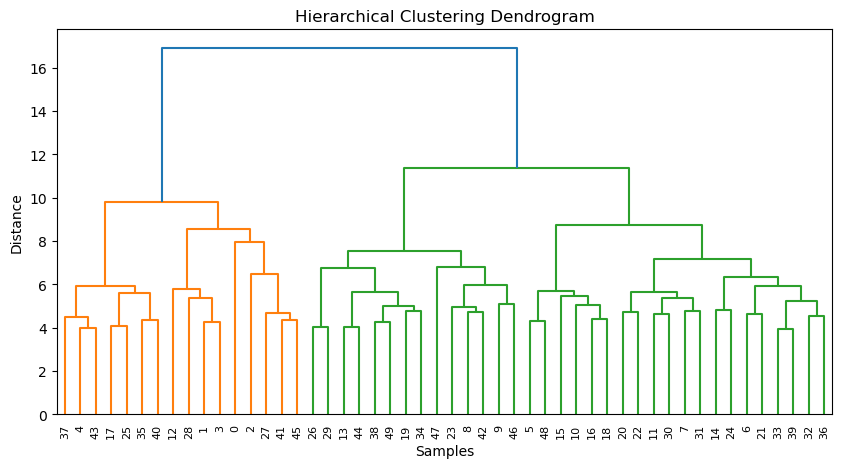

In [27]:
# Convert sparse matrix to dense
X_dense = X_preprocessed[:50].toarray()  # take first 500 samples for speed

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X_dense, method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()
